To run the notebook, the wd in cell below needs to be changed to the locatation of git repository
In addition, to two files need to be extracted using gunzip:
/InputData/coverageDFwithExons.pkl.gz and 
/OutputData/exonsMatrixV3.pkl.gz


In [1]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import umap #this is umap-learn library, not umap (which is charting library)
import math
from sklearn.manifold import TSNE, MDS, Isomap
from textwrap import wrap
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import hdbscan
from collections import Counter
from scipy.stats import fisher_exact
from os import  listdir
from os.path import  isfile, join, splitext
from Bio import SeqIO
#start with coverage of features by reads
#run calculatedCoverage.sh and CalculateCoverage.py to get the tsv file below
wd="/mnt/storage5/anton/Mosquitoes/ResistanceGenes/" #<---- change to the location of git repository
inputData=wd+"/InputData/"
outputData=wd+"/OutputData/"


The raw data is split into samples metadata SampleRegions.txt and matrix consisting of exons exonsMatrixV3.pkl. Exons are used because Ae. aegypti genome has vast number of repetetive elements and these cannot be reliably aligned, nor can SNPs be called using short read data.

The data matrix has one row per each nucleotide variant (i.e. a single SNP results in two rows: Ref and Alt) and two types of columns. First type are one column per sample. These columns have values 0 or 1 where 1 indicates that the variant is present in the sample. Second type contain nucleotide variant metadata: GeneticRegion (chr), isExon, isCDS, ismRNA, Pos (coordinate of nucleotide in GeneticRegion i.e. chr), Gene (gene ID), AlleleSequence, SNPType (RERENCE, ALT, NoCall), snpEffectImpact and snpEffectOntology (both based on snpEff nomenclature determined based on gene in Gene column), AAchange (if applicable, the amino acid change caused by the AlleleSequence based on gene in Gene column)

(47143, 747)
(47143, 747)


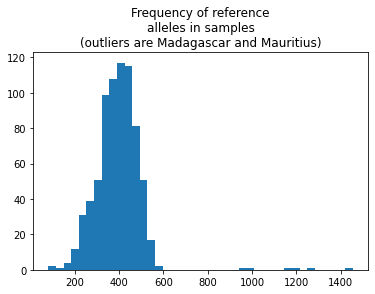

In [2]:
metadata=pd.read_csv(f'{inputData}/SampleRegions.txt',sep="\t", index_col=0, names=["SampleID","Country","SubRegion","Region","Location", "Type"])

ExcludeRegions=[]
ExcludeSamples=[]
ExcludeSamples=["SRR14609304","SRR14609305","SRR14609308","SRR14609309","SRR14609307","SRR11006790"] #exom sequencing (SRR146###), no SNPs (SRR11006790)
ExcludeSamples=ExcludeSamples+["SRR11006849", "SRR11006876", "SRR11006886", "SRR11006937", "SRR11006761", "SRR11006764", "SRR11006625","SRR11006688"] #bad coverage, SRR11006688 - likely mislabelled
ExcludeSamples=ExcludeSamples+["SRR11006793","SRR11006811","SRR11006823","SRR11006846","SRR5562870"] #abnormally limited coverage
#no geographic pattern: Kenya x3, Uganda x1, Senegal x1, Burkina Faso x1, Brazil x1
#ExcludeSamples=ExcludeSamples+["ERR4065454","ERR4065455","ERR4065456","ERR4065457","ERR4065458","ERR4065459","ERR4065460","ERR4065462","ERR4065463"] #French Polynesia/Bora-Bora colony
#ExcludeSamples=ExcludeSamples+["SRR11006707","SRR11006708","SRR11006709","SRR11006710","SRR9959076","SRR9959082","SRR9959083"] # Madagasacar/Mauritius


alleles_df=pd.read_pickle(outputData+"/exonsMatrixV3.pkl") #use exons only instead of whole gene neigbourhoods because TEs bring a lot of noise and misalignment



nonNumericColumns=["GeneticRegion","isExon","isCDS","ismRNA","Pos",'Gene','AlleleSequence','SNPType','snpEffectImpact','snpEffectOntology','AAchange']
numericColumns=[x for x in alleles_df.columns if x not in nonNumericColumns and x not in ExcludeSamples]
#drop the rows with only 0's. When generating exonsMatrixV2.pkl, each position got extra row to accomodate NoCall of nucleotide, but in most cases, these rows remained unused
#they contribute nothing to analysis and are removed:
alleles_df=alleles_df.loc[np.sum(alleles_df.drop(columns=nonNumericColumns),axis=1)!=0].copy()

#In some cases, there are two references for the same position. 
#This is the result of each sample variants being called separately. 
#In this case, more complex variants sometimes give rise to additional REFERENCE line. 
#Because the reference sequence (unlike ALT sequences) is not actually used here, the REFERENCE lines should be merged

indices_to_drop=[]
for gene in np.unique(alleles_df["Gene"]):
    first_instance_index={}
    position_instance_count=Counter(alleles_df.loc[  (alleles_df["SNPType"] == "REFERENCE") & (alleles_df["Gene"] == gene) ]["Pos"])
    for index in alleles_df.loc[  (alleles_df["SNPType"] == "REFERENCE") & (alleles_df["Gene"] == gene) ].index:
        if position_instance_count[ alleles_df.loc[index, "Pos"] ] >1:
            if alleles_df.loc[index, "Pos"] not in first_instance_index:
                first_instance_index[alleles_df.loc[index, "Pos"]]=index
            else:
                alleles_df.loc[ first_instance_index[alleles_df.loc[index, "Pos"]] , numericColumns  ] += alleles_df.loc[ first_instance_index[alleles_df.loc[index, "Pos"]] , numericColumns  ]
                indices_to_drop.append(index)
print(alleles_df.shape)
alleles_df.drop(indices_to_drop, axis=0, inplace=True)
alleles_df.replace(range(2,np.max(np.max(alleles_df[numericColumns]))+1), 1, inplace=True) # replace the results of summation above with 1
print(alleles_df.shape)

#cast sample binary columns to integer type and position on chromosome to numeric
alleles_df[ numericColumns ]=alleles_df[ numericColumns ].astype(int) 
alleles_df['Pos'] = pd.to_numeric(alleles_df['Pos'])

plt.hist(Counter(alleles_df["SNPType"]=="REFERENCE")[True]-np.sum(alleles_df.loc[alleles_df["SNPType"]=="REFERENCE"][numericColumns],axis=0), bins=40)
plt.title("Frequency of reference\nalleles in samples\n(outliers are Madagascar and Mauritius)")
plt.show()

alleles_df.drop([f for f in ExcludeSamples if f in alleles_df.columns], axis=1,inplace=True)

# the genes has double mutation on same reads: 351634752 A->C and 351634753 G->C
# snpEff doesn't aggregate them which leads to two AA substitutions p.Glu178Ala and p.Glu178Asp instead of one:
# the two mutations always occur as a pair
# This fixes the incorrect amino acid substitutions (the raw data has p.Glu178Asp)
alleles_df.loc[ (alleles_df["Pos"]==351634753) & (alleles_df["Gene"]=="XM_021846286.1") & (alleles_df["AAchange"]=="p.Glu178Asp"), "AAchange"] = "p.Glu178Ala"


metadata=metadata.loc[numericColumns]



The file GenesList.tsv contains metadata on all the genes used in the analysis.

In [3]:
genesList=pd.read_csv(inputData+"GenesList.tsv", sep="\t", index_col=0, header=0)


Three samples from western Kenya (Kakamegax2, Virhembex1) and one from Uganda fall within the eastern Kenya UMAP cluster

In [5]:
metadata.loc[ (metadata["Region"]=="East Kenya and South Africa") &  
             ( (metadata["SubRegion"]=="West Kenya") |  (metadata["SubRegion"]=="Uganda")) ]


,Country,SubRegion,Region,Location,Type
SampleID,,,,,
SRR11006697,Kenya,West Kenya,East Kenya and South Africa,Kenya: Kakamega,Wild
SRR11006705,Kenya,West Kenya,East Kenya and South Africa,Kenya: Kakamega,Wild
SRR11006885,Kenya,West Kenya,East Kenya and South Africa,Kenya: Virhembe,Wild
SRR11006909,Uganda,Uganda,East Kenya and South Africa,Uganda: Kichwamba,Wild


To maintain same colour for plotted series, the colours are defined here. The "Region" is based on results of analysis, i.e. it's not part of original metadata, but rather result of clustering analysis performed here. 

In [6]:
regionColoursDic={}
regionsPresent=list(set(metadata["Region"]))
regionsPresent.sort()
regionsCmap=plt.cm.get_cmap('tab10', len(regionsPresent))
for region in regionsPresent:
    regionColoursDic[region]=regionsCmap( len(regionColoursDic) / len( regionsPresent ) )

countryColoursDic={}
country_legend_elements=[]
countriesPresent=set(metadata["Country"])
regionsCmap=plt.cm.get_cmap('tab10', min(len(countriesPresent),10))
for country in sorted(Counter( metadata["Country"] ).items(), key=lambda x: x[1], reverse=True):
    if len(countryColoursDic)<9:
        countryColoursDic[country[0]]=regionsCmap( len(countryColoursDic) / 10 )
        country_legend_elements.append(mpatches.Patch(color=countryColoursDic[country[0]], label=country[0]))
    else:
        countryColoursDic[country[0]]=regionsCmap( 1 )
        country_legend_elements.append(mpatches.Patch(color=countryColoursDic[country[0]], label="Other"))


In [7]:
def get_mutations(data, mut_type):
    if mut_type=="synonymous":
        return (data["snpEffectOntology"]=="splice_region_variant&synonymous_variant") | (data["snpEffectOntology"]=="synonymous_variant")
    elif mut_type=="missense":
        return (data["snpEffectOntology"]=="missense_variant&splice_region_variant") | (data["snpEffectOntology"]=="missense_variant")
    elif mut_type=="high":    
        return (data["snpEffectImpact"]=="HIGH")
    elif mut_type=="modifier":    
        return (data["snpEffectImpact"]=="MODIFIER")
    else:
        print(f'Unknown mutation type: {mut_type}')

Plot location of SNPs on the chromosomes, but don't show SNPs that occur in single isolate to aid clarity.

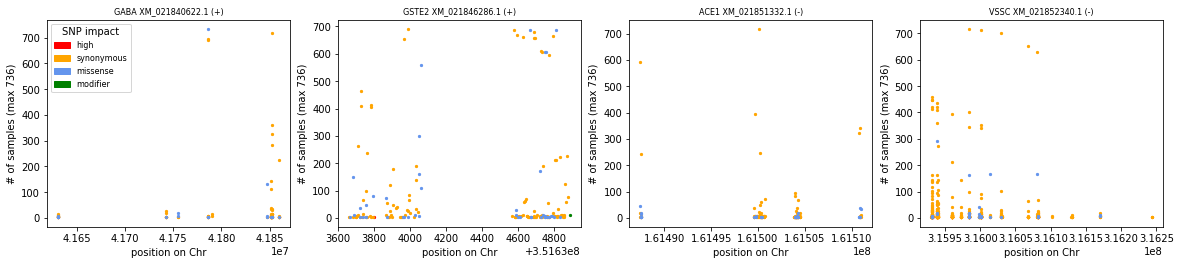

In [8]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(1)
fig.set_figwidth(20)
fig.subplots_adjust(top=3)

snpImpactLegend={"high":"red","synonymous":"orange","missense":"cornflowerblue","modifier":"green"}
legendElements=[]
for key in snpImpactLegend:
    legendElements.append(mpatches.Patch(color=snpImpactLegend[key], label=key))

for column, gene in enumerate(genesList.loc[genesList["IsResistance"]].index):
    for impact in ["high","synonymous","missense","modifier"]:
        mask=alleles_df.index[ (np.sum(alleles_df[numericColumns],axis=1)>1 ) & (np.sum(alleles_df[numericColumns],axis=1)<(len(numericColumns)-1) ) &
                         (alleles_df["Gene"]==gene) & (alleles_df["SNPType"]!="REFERENCE") & get_mutations(alleles_df, impact) & (alleles_df["isCDS"]) ]
        axs[column].scatter(alleles_df.loc[mask]["Pos"],np.sum(alleles_df.loc[mask][ [x for x in alleles_df.columns if x not in nonNumericColumns] ],axis=1), c=snpImpactLegend[impact], s=15 if impact=="HIGH" else 5)
    axs[column].set_title(f'{genesList.loc[gene]["Name"]} {gene} ({genesList.loc[gene]["Orientation"]})',size=8 )
    axs[column].set_xlabel("position on Chr")
    axs[column].set_ylabel("# of samples (max "+str(len(numericColumns))+")")
axs[0].legend(handles=legendElements,prop={'size': 8}, loc="best", title="SNP impact")
plt.show()

Determine the SNP frequency per 1000nt for each gene

In [9]:
genesList["missence_SNP_frequency"]=0.0
genesList["unique_aa_substitutions"]=0
genesList["synonimous_SNP_frequency"]=0.0
for gene in genesList.index:
    rows_subset = alleles_df.loc[ (alleles_df["Gene"]==gene) & get_mutations(alleles_df,"missense" ) & (alleles_df["isCDS"]==True)]
    genesList.at[gene,"unique_missence_SNP"] =  len( rows_subset) 
    genesList.at[gene,"unique_aa_substitutions"] = len( set([rows_subset.loc[f,"AAchange"] for f  in rows_subset.index if rows_subset.loc[f,"AAchange"]!="NA" ]) )
    #snpEff classifies insertions/deletions are NA
    rows_subset = alleles_df.loc[ (alleles_df["Gene"]==gene) & get_mutations(alleles_df,"synonymous" ) & (alleles_df["isCDS"]==True) ]
    genesList.at[gene,"unique_synonimous_SNP"] =  len( rows_subset)  


genesList.at[gene,"missence_SNP_frequency"] = len( alleles_df.loc[ (alleles_df["Gene"]=="YP_009389261.1")  & (alleles_df["isCDS"]==True)]  ) / float(genesList.at["YP_009389261.1","CDSLen"]) * 1000 
genesList.to_csv(f'{outputData}/TableA.tsv',sep="\t")

The numbers for the main article text

Numbers for the "Results" section

In [10]:
from scipy.stats import pearsonr
print(f'WGS libraries: {len(numericColumns)}')
print(f'Countries: {Counter( [ metadata.at[f,"Country"] for f in numericColumns ] )}')
print(f'GSTe2 { np.round(genesList.at["XM_021846286.1","missence_SNP_frequency"],0) }')
print(f'ACE1 { np.round(genesList.at["XM_021851332.1","missence_SNP_frequency"],0) }')
print(f'VSSC { np.round(genesList.at["XM_021852340.1","missence_SNP_frequency"],0) }')
print(f'GABA/rdl { np.round(genesList.at["XM_021840622.1","missence_SNP_frequency"],0) }')
print(f'XM_021857384.1 (Non-resistance) { np.round(genesList.at["XM_021857384.1","missence_SNP_frequency"],0) }')
print(f'XM_001649790.2 (Non-resistance) { np.round(genesList.at["XM_001649790.2","missence_SNP_frequency"],0) }')
print(f'Pearson R^2 { pearsonr(genesList["missence_SNP_frequency"],genesList["synonimous_SNP_frequency"])[0] }')
print(f'cox1 SNP (both types) frequency { np.round(genesList.at["YP_009389261.1","missence_SNP_frequency"],0) }')


WGS libraries: 736
Countries: Counter({'USA': 161, 'Kenya': 158, 'Senegal': 110, 'Ghana': 58, 'Gabon': 56, 'Uganda': 39, 'Burkina Faso': 34, 'Thailand': 28, 'Nigeria': 19, 'Brazil': 16, 'American Samoa': 16, 'Mexico': 15, 'French Polynesia': 9, 'LAB': 6, 'Madagascar': 4, 'Mauritius': 3, 'S. Africa': 2, 'Australia': 1, 'Costa Rica': 1})
GSTe2 0.0
ACE1 0.0
VSSC 0.0
GABA/rdl 0.0
XM_021857384.1 (Non-resistance) 0.0
XM_001649790.2 (Non-resistance) 0.0
Pearson R^2 nan
cox1 SNP (both types) frequency 753.0


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Numbers for the Population Structure section

In [11]:
print("Non-resistance missense and synonymous SNPs:")
#ALL
missense_mutations=len(alleles_df.index[ (alleles_df["isCDS"]) & (alleles_df["SNPType"]=="ALT") & get_mutations(alleles_df, "missense")  &
    ( alleles_df["Gene"].isin(  genesList.index[genesList["IsResistance"]==False] ))   &  ( alleles_df["Gene"] != "YP_009389261.1	") ] ) 
synonymous_mutations=len(alleles_df.index[ (alleles_df["isCDS"]) & (alleles_df["SNPType"]=="ALT") & get_mutations(alleles_df, "synonymous")  &
    ( alleles_df["Gene"].isin(  genesList.index[genesList["IsResistance"]==False] ))   &  ( alleles_df["Gene"] != "YP_009389261.1	") ] ) 
print(f'Non-resistance genes: Syn: {synonymous_mutations}, Missense:{missense_mutations}, Total:{synonymous_mutations+missense_mutations}')
print( Counter([metadata.at[f,"Region"] for f in numericColumns  ]) )

#Resistance only
missense_mutations=len(alleles_df.index[ (alleles_df["isCDS"]) & (alleles_df["SNPType"]=="ALT") & get_mutations(alleles_df, "missense")  &
    ( alleles_df["Gene"].isin(  genesList.index[genesList["IsResistance"]==True] ))   &  ( alleles_df["Gene"] != "YP_009389261.1	") ] ) 
synonymous_mutations=len(alleles_df.index[ (alleles_df["isCDS"]) & (alleles_df["SNPType"]=="ALT") & get_mutations(alleles_df, "synonymous")  &
    ( alleles_df["Gene"].isin(  genesList.index[genesList["IsResistance"]==True] ))   &  ( alleles_df["Gene"] != "YP_009389261.1	") ] ) 
print(f'Resitance genes: Syn: {synonymous_mutations}, Missense:{missense_mutations}, Total:{synonymous_mutations+missense_mutations}')
print( Counter([metadata.at[f,"Region"] for f in numericColumns  ]) )


#Identify COX1 (mitochondrial gene) multiploidy that is likely result of copies of mitochondrial genome embedded on chromosomes
#Identify COX1 (mitochondrial gene) multiploidy that is likely result of copies of mitochondrial genome embedded on chromosomes
temp=pd.pivot_table ( alleles_df.loc[ (alleles_df["Gene"] == "YP_009389261.1")  ], 
                index=["Pos"], values=numericColumns, aggfunc=np.sum)[ numericColumns ]
excess_mito_ploidy=pd.DataFrame(index=numericColumns,data=np.sum(temp, axis=0)-len(temp.index), columns=["Cases of excess ploidy"])
excess_mito_ploidy["Geography"]=[metadata.at[f,"Region"] for f in excess_mito_ploidy.index]
print(f'Mitochondrial cox1 ploidy: {Counter(excess_mito_ploidy["Cases of excess ploidy"])}')
excess_mito_ploidy.to_csv(f'{outputData}/temp.tsv', sep="\t")

alleles_df.loc[ (alleles_df["Gene"].isin(  genesList.index[ (genesList["IsResistance"]==True)] ) ) & (alleles_df["SNPType"]=="ALT" ) ].to_csv(f'{outputData}/Supplementary_Table_B.tsv', sep="\t")

Non-resistance missense and synonymous SNPs:
Non-resistance genes: Syn: 5576, Missense:4097, Total:9673
Counter({'West and Central Africa': 349, 'Americas, Thailand and other': 258, 'East Kenya and South Africa': 113, 'French Polynesia (Bora-Bora)': 9, 'Madagascar and Mauritius (Ae. mascarensis)': 7})
Resitance genes: Syn: 1355, Missense:474, Total:1829
Counter({'West and Central Africa': 349, 'Americas, Thailand and other': 258, 'East Kenya and South Africa': 113, 'French Polynesia (Bora-Bora)': 9, 'Madagascar and Mauritius (Ae. mascarensis)': 7})
Mitochondrial cox1 ploidy: Counter({0: 335, 1: 75, 2: 50, 3: 31, 9: 20, 4: 18, 10: 16, 7: 15, 11: 14, 12: 11, 8: 10, 5: 8, 6: 6, 14: 6, 30: 6, 44: 6, 27: 5, 21: 5, 22: 4, 43: 4, 46: 4, 37: 4, 13: 3, 58: 3, 23: 3, 45: 3, 73: 3, 57: 3, 41: 3, 59: 3, 48: 3, 53: 3, 40: 3, 20: 3, 34: 3, 15: 2, 17: 2, 50: 2, 66: 2, 47: 2, 52: 2, 78: 2, 67: 2, 62: 2, 56: 2, 16: 2, 25: 2, 140: 1, 90: 1, 49: 1, 69: 1, 51: 1, 26: 1, 39: 1, 92: 1, 29: 1, 87: 1, 42: 1, 

Numbers for the VGSC section

In [12]:
figures_data=alleles_df.loc[ (alleles_df["Gene"] == "XM_021852340.1" )  & (alleles_df["SNPType"]=="ALT" ) &
                             (get_mutations(alleles_df, "missense") | get_mutations(alleles_df, "synonymous")  ) &
                               (alleles_df["isCDS"] ) ].copy()
print( f'# of missense SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense")  ])}'  )
print( f'# of synonymous SNPs  {len(figures_data.loc[ get_mutations(alleles_df, "synonymous") ])}'  )
samples_per_snp=figures_data.loc[ get_mutations(figures_data, "missense") ].copy()
samples_per_snp["NumberOfSamples"]=np.sum(samples_per_snp[numericColumns],axis=1)
samples_per_snp.sort_values(by=["NumberOfSamples"],ascending=False, inplace=True)
print(f'SNP in more than one sample: {Counter( samples_per_snp.loc[ get_mutations(figures_data, "missense")  ] ["NumberOfSamples"]>1)[True]}'  )
for i, index in enumerate(samples_per_snp.index):
    if i<8:
        samples_with_AA_change=samples_per_snp.loc[index, "NumberOfSamples"]
        print(f'{alleles_df.loc[index,"AAchange"]}  {samples_per_snp.loc[index, "Pos"]} {samples_with_AA_change} i.e. {round(samples_with_AA_change/len(numericColumns),2)} ')

s_w_Africa=[f for f in numericColumns if metadata.at[f,"Region"]=="West and Central Africa"    ]
samples_with_2050_G=len([column  for column in s_w_Africa if alleles_df.loc[ (alleles_df["Pos"]==315931071) & (alleles_df["AlleleSequence"]=="ACCGCCGCCG") ].iloc[0][column]==1])
samples_with_2015S_SG=len([column  for column in s_w_Africa if alleles_df.loc[ (alleles_df["Pos"]==315931174) & (alleles_df["AlleleSequence"]=="GCACCAC") ].iloc[0][column]==1])
samples_with_both=len(np.intersect1d([column  for column in s_w_Africa if alleles_df.loc[ (alleles_df["Pos"]==315931071) & (alleles_df["AlleleSequence"]=="ACCGCCGCCG") ].iloc[0][column]==1],
    [column  for column in numericColumns if alleles_df.loc[ (alleles_df["Pos"]==315931174) & (alleles_df["AlleleSequence"]=="GCACCAC") ].iloc[0][column]==1]))
total_west_african_samples=len(s_w_Africa)
chi2_table = np.array( [ [samples_with_both,  samples_with_2050_G-samples_with_both    ],
                [samples_with_2015S_SG-samples_with_both, total_west_african_samples-(samples_with_2050_G+samples_with_2015S_SG)+samples_with_both    ] ] ) 
print(chi2_contingency(chi2_table))

# of missense SNPs 202
# of synonymous SNPs  873
SNP in more than one sample: 36
p.Phe1554Cys  315939224 290 i.e. 0.39 
p.Ser711Thr  316014588 166 i.e. 0.23 
p.Val408Leu  316080722 165 i.e. 0.22 
p.Val1012Ile  315983763 161 i.e. 0.22 
p.Met940Val  315998396 42 i.e. 0.06 
p.Asp1653Glu  315938859 18 i.e. 0.02 
p.Ser985Pro  315984077 18 i.e. 0.02 
p.Leu942Gln  315998389 16 i.e. 0.02 
(0.15603819466322252, 0.6928305620263866, 1, array([[ 12.3782235,  67.6217765],
       [ 41.6217765, 227.3782235]]))


Numbers for rdl/GABA section

In [13]:
figures_data=alleles_df.loc[ (alleles_df["Gene"] == "XM_021840622.1" )  & (alleles_df["SNPType"]=="ALT" ) & (alleles_df["isCDS"] ) ].copy()
print( f'# of all SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense")  | get_mutations(figures_data, "synonymous")  ])}'  )
print( f'# of missense SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense") ])}'  )
print( f'# of synonymous SNPs  {len(figures_data.loc[ get_mutations(figures_data, "synonymous") ])}'  )
samples_per_snp=figures_data.loc[ get_mutations(figures_data, "missense") ].copy()
samples_per_snp["NumberOfSamples"]=np.sum(samples_per_snp[numericColumns],axis=1)
samples_per_snp.sort_values(by=["NumberOfSamples"],ascending=False, inplace=True)
print(f'SNP in more than one sample: {Counter( samples_per_snp.loc[ get_mutations(figures_data, "missense")  ] ["NumberOfSamples"]>1)[True]}'  )
for i, index in enumerate(samples_per_snp.index):
    if i<5:
        print(f'{alleles_df.loc[index,"AAchange"]}  {samples_per_snp.loc[index, "Pos"]} {samples_per_snp.loc[index, "NumberOfSamples"]}')



# of all SNPs 244
# of missense SNPs 64
# of synonymous SNPs  180
SNP in more than one sample: 17
p.Ser110Thr  41786063 733
p.Ala296Ser  41847790 131
p.Glu79Asp  41755106 18
p.Pro76Leu  41755096 9
p.Val327Ile  41847883 6


Numbers for Ace-1

In [14]:
figures_data=alleles_df.loc[ (alleles_df["Gene"] == "XM_021851332.1" )  & (alleles_df["SNPType"]=="ALT" ) & (alleles_df["isCDS"] ) ].copy()
print( f'# of all SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense")  | get_mutations(figures_data, "synonymous")  ])}'  )
print( f'# of missense SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense") ])}'  )
print( f'# of synonymous SNPs  {len(figures_data.loc[ get_mutations(figures_data, "synonymous") ])}'  )
samples_per_snp=figures_data.loc[ get_mutations(figures_data, "missense") ].copy()
samples_per_snp["NumberOfSamples"]=np.sum(samples_per_snp[numericColumns],axis=1)
samples_per_snp.sort_values(by=["NumberOfSamples"],ascending=False, inplace=True)
print(f'SNP in more than one sample: {Counter( samples_per_snp.loc[ get_mutations(figures_data, "missense")  ] ["NumberOfSamples"]>1)[True]}'  )
for i, index in enumerate(samples_per_snp.index):
    if i<5:
        #print(f'{alleles_df.loc[index,"AAchange"]}  {samples_per_snp.loc[index, "Pos"]} {samples_per_snp.loc[index, "NumberOfSamples"]}')
        samples_with_AA_change=samples_per_snp.loc[index, "NumberOfSamples"]
        print(f'{alleles_df.loc[index,"AAchange"]}  {samples_per_snp.loc[index, "Pos"]} {samples_with_AA_change} i.e. {round(samples_with_AA_change/len(numericColumns),2)*100} ')



# of all SNPs 243
# of missense SNPs 99
# of synonymous SNPs  144
SNP in more than one sample: 30
p.Cys699Ser  161487441 44 i.e. 6.0 
p.His35Leu  161510922 37 i.e. 5.0 
p.Gly12Ser  161510992 35 i.e. 5.0 
p.Asp131Glu  161504294 20 i.e. 3.0 
p.Ser693Leu  161487459 20 i.e. 3.0 


numbers for GSTe2

In [15]:
figures_data=alleles_df.loc[ (alleles_df["Gene"] == "XM_021846286.1" )  & (alleles_df["SNPType"]=="ALT" ) & (alleles_df["isCDS"] ) ].copy()
print( f'# of all SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense")  | get_mutations(figures_data, "synonymous")  ])}'  )
print( f'# of missense SNPs {len(figures_data.loc[ get_mutations(figures_data, "missense") ])}'  )
print( f'# of synonymous SNPs  {len(figures_data.loc[ get_mutations(figures_data, "synonymous") ])}'  )
samples_per_snp=figures_data.loc[ get_mutations(figures_data, "missense") ].copy()
samples_per_snp["NumberOfSamples"]=np.sum(samples_per_snp[numericColumns],axis=1)
samples_per_snp.sort_values(by=["NumberOfSamples"],ascending=False, inplace=True)
print(f'SNP in more than one sample: {Counter( samples_per_snp.loc[ get_mutations(figures_data, "missense")  ] ["NumberOfSamples"]>1)[True]}'  )
for i, index in enumerate(samples_per_snp.index):
    if i<5:
        print(f'{alleles_df.loc[index,"AAchange"]}  {samples_per_snp.loc[index, "Pos"]} {samples_per_snp.loc[index, "NumberOfSamples"]}')




# the genes has double mutation on same reads: 351634752 A->C and 351634753 G->C
# snpEff doesn't aggregate them which leads to two AA substitutions p.Glu178Ala and p.Glu178Asp instead of one:
# the two mutations always occur as a pair. This is remedied when raw data is loaded

samples_with_Cys115Ser=len([column  for column in numericColumns if alleles_df.loc[ (alleles_df["Gene"] == "XM_021846286.1" ) & (alleles_df["AAchange"]=="p.Cys115Ser") ].iloc[0][column]==1])
samples_with_Cys115Phe=len([column  for column in numericColumns if alleles_df.loc[ (alleles_df["Gene"] == "XM_021846286.1" ) & (alleles_df["AAchange"]=="p.Cys115Phe") ].iloc[0][column]==1])
samples_with_both=len(np.intersect1d([column  for column in numericColumns if alleles_df.loc[ (alleles_df["Gene"] == "XM_021846286.1" ) & (alleles_df["AAchange"]=="p.Cys115Ser") ].iloc[0][column]==1],
    [column  for column in numericColumns if alleles_df.loc[ (alleles_df["Gene"] == "XM_021846286.1" ) & (alleles_df["AAchange"]=="p.Cys115Phe") ].iloc[0][column]==1]))
chi2_table = np.array( [ [samples_with_both,  samples_with_Cys115Ser-samples_with_both    ],
                [samples_with_Cys115Phe-samples_with_both, len(numericColumns)-(samples_with_Cys115Ser+samples_with_Cys115Phe)+samples_with_both    ] ] ) 
print(chi2_contingency(chi2_table))



# of all SNPs 267
# of missense SNPs 109
# of synonymous SNPs  158
SNP in more than one sample: 42
p.Ala198Glu  351634812 687
p.Ile150Val  351634667 686
p.Glu178Ala  351634752 607
p.Glu178Ala  351634753 607
p.Cys115Phe  351634060 559


(19.71624869450369, 8.983428209087592e-06, 1, array([[ 82.78668478,  26.21331522],
       [476.21331522, 150.78668478]]))


Coverage data analysis using individual violin plots
The figures summarise the per-position read depth normalised by the median read depth across all except two genes for a given library. 
Genes VGSC and GSTe2 are excluded from calculation of sample median depth because they had probabable gene duplication events. 


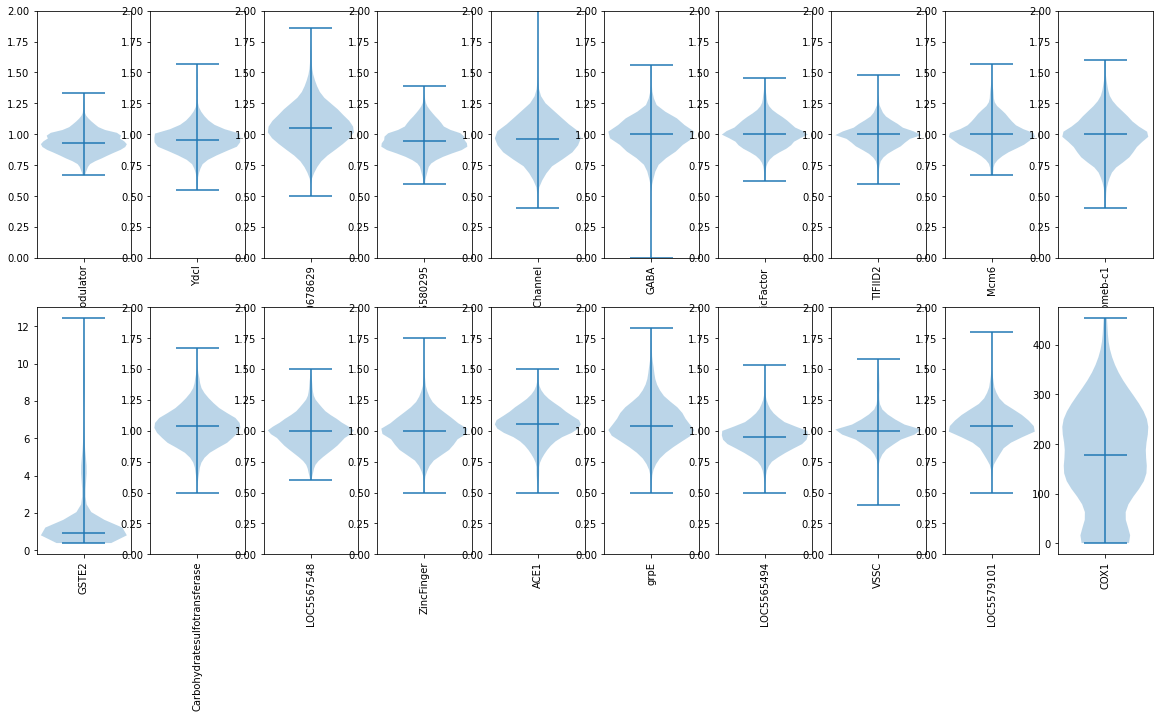

In [16]:
coverageData=pd.read_pickle(inputData+"/coverageDFwithExons.pkl")
for sample in numericColumns:
    coverageData[sample]=coverageData[sample] / np.median( coverageData.loc[ (coverageData["isCDS"]==True) & (~coverageData["Gene"].isin(["XM_021846286.1","XM_021852340.1" ]))   ,  sample] )


fig, axs = plt.subplots(2, int(genesList.shape[0]/2))
fig.set_size_inches(20,10)
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
for i, gene in enumerate(genesList.index):
    violinData=[]
    xaxisLabels=[]
    violinData.append( list(np.median(coverageData.loc[ (coverageData["Gene"]==gene) & (coverageData["isCDS"]==True)][numericColumns], axis=0 ) ) )
    xaxisLabels.append( genesList.at[gene,"Name"] ) 
    row = 0 if i<int(genesList.shape[0]/2) else 1
    column = i - row * int(genesList.shape[0]/2)
    
    axs[row, column].violinplot(violinData, points=30, bw_method="silverman", showmedians=True)
    axs[row, column].set_xticks(np.arange(1, len(xaxisLabels) + 1))
    axs[row, column].set_xticklabels(xaxisLabels)
    axs[row, column].tick_params(axis='x', rotation=90)
    if genesList.at[gene,"Name"]!="COX1" and genesList.at[gene,"Name"]!="GSTE2": #COX 1 will have very high coverage
        axs[row, column].set_ylim([0,2])
    #axs[row, column].set_title("Read Coverage (1 expected)")
plt.show()



Coverage data analysis using kernel density for Thai samples only. The excess coverage of GSTe2 is clearly visible.

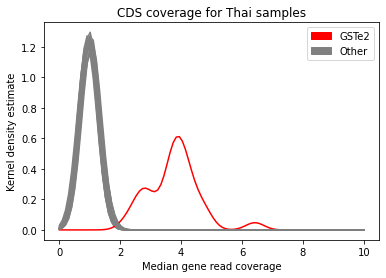

In [17]:
from sklearn.neighbors import KernelDensity
import numpy as np

thai_samples=[f for f in numericColumns if metadata.at[f,"Country"]=="Thailand"]
for i, gene in enumerate(genesList.index):
    if genesList.at[gene,"Name"]=="COX1":
        continue
    violinData=[]
    xaxisLabels=[]
    violinData.append( list(np.median(coverageData.loc[ (coverageData["Gene"]==gene) & (coverageData["isCDS"]==True)][thai_samples], axis=0 ) ) )
    xaxisLabels.append( genesList.at[gene,"Name"] ) 
    row = 0 if i<int(genesList.shape[0]/2) else 1
    column = i - row * int(genesList.shape[0]/2)
    
    X = np.asarray(np.median(coverageData.loc[ (coverageData["Gene"]==gene) & (coverageData["isCDS"]==True)][thai_samples], axis=0 ).reshape(-1, 1) )
    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(X)
    log_dens = kde.score_samples(np.linspace(0, 10, 100).reshape(-1, 1))

    plt.plot( np.linspace(0, 10, 100)  , np.exp(log_dens), c="red" if genesList.at[gene,"Name"]=="GSTE2" else "grey" )
    plt.xlabel("Median gene read coverage")
    plt.ylabel("Kernel density estimate")

plt.legend( handles=[mpatches.Patch(color="red", label="GSTe2"),mpatches.Patch(color="grey", label="Other")] )  #.legend(handles=legendElements,prop={'size': 8}, loc="best", title="SNP impact")
plt.title("CDS coverage for Thai samples")
plt.show()



Examine the coverage to identify groups of isolates with unusual/distinct coverage: VSSC and GSTe2 are such cases.

In [18]:
genes_to_plot={"XM_021852340.1":"VSSC", "XM_021851332.1":"ACE1","XM_021846286.1":"GSTE2", "XM_021840622.1":"GABA"}
for gene_id, gene_name in genes_to_plot.items():
    #add this to metadata to create table with coverage values and country values - this minimises redundancy of published tables.
    metadata[f'{gene_name}  median coverage']=np.median(coverageData.loc[ (coverageData["Gene"]==gene_id) & (coverageData["isCDS"]==True)][metadata.index],axis=0)
    
metadata.to_csv(f'{outputData}/Supp_TableA.tsv',sep="\t")

Examine the coverage of four insecticide resistance linked genes. VSSC and GSTe2 have distinct clusters implying gene duplication events.

Counter({1: 710, 0: 26})
VSSC cluster 0 median coverage: 1.3529411764705883
VSSC cluster 1 median coverage: 1.0


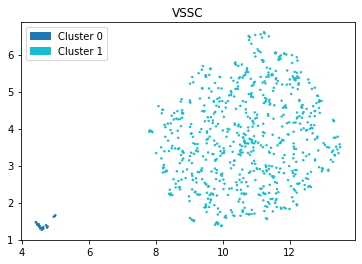

Cluster              0      1
Country                      
American Samoa     4.0   12.0
Australia          NaN    1.0
Brazil             NaN   16.0
Burkina Faso       NaN   34.0
Costa Rica         NaN    1.0
French Polynesia   NaN    8.0
Gabon              NaN   56.0
Ghana              NaN   58.0
Kenya              1.0  157.0
LAB                NaN    6.0
Madagascar         NaN    4.0
Mauritius          2.0    1.0
Mexico             2.0   13.0
Nigeria            NaN   19.0
S. Africa          NaN    2.0
Senegal           13.0   97.0
Thailand           1.0   27.0
USA                3.0  158.0
Uganda             NaN   39.0
Counter({1: 532, -1: 173, 0: 31})
ACE1 cluster -1 median coverage: 1.05
ACE1 cluster 0 median coverage: 0.8461538461538461
ACE1 cluster 1 median coverage: 1.0666666666666667


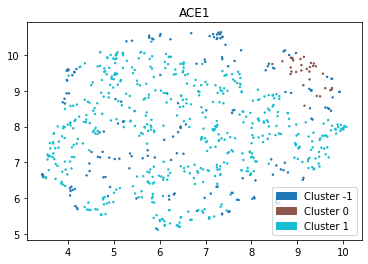

Cluster             -1     0      1
Country                            
American Samoa     3.0   NaN   13.0
Australia          1.0   NaN    NaN
Brazil             3.0   NaN   13.0
Burkina Faso       8.0   NaN   26.0
Costa Rica         NaN   NaN    1.0
French Polynesia   NaN   1.0    7.0
Gabon             11.0   2.0   43.0
Ghana             10.0   NaN   48.0
Kenya             43.0   4.0  111.0
LAB                3.0   NaN    3.0
Madagascar         1.0   NaN    3.0
Mauritius          2.0   NaN    1.0
Mexico             3.0   NaN   12.0
Nigeria            5.0   2.0   12.0
S. Africa          NaN   NaN    2.0
Senegal           16.0   3.0   91.0
Thailand           7.0   1.0   20.0
USA               48.0  16.0   97.0
Uganda             9.0   2.0   28.0
Counter({0: 639, 2: 73, 1: 24})
GSTE2 cluster 0 median coverage: 0.9166666666666666
GSTE2 cluster 1 median coverage: 9.28
GSTE2 cluster 2 median coverage: 4.2


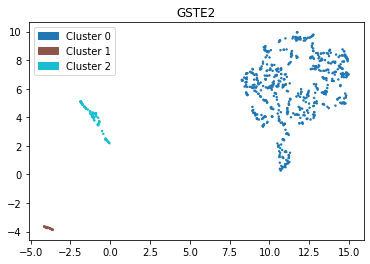

Cluster               0     1     2
Country                            
American Samoa     16.0   NaN   NaN
Australia           1.0   NaN   NaN
Brazil             15.0   NaN   1.0
Burkina Faso       34.0   NaN   NaN
Costa Rica          1.0   NaN   NaN
French Polynesia    8.0   NaN   NaN
Gabon              56.0   NaN   NaN
Ghana              58.0   NaN   NaN
Kenya             158.0   NaN   NaN
LAB                 4.0   NaN   2.0
Madagascar          4.0   NaN   NaN
Mauritius           3.0   NaN   NaN
Mexico              1.0   9.0   5.0
Nigeria            19.0   NaN   NaN
S. Africa           2.0   NaN   NaN
Senegal           110.0   NaN   NaN
Thailand            1.0   NaN  27.0
USA               108.0  15.0  38.0
Uganda             39.0   NaN   NaN
Counter({2: 447, -1: 251, 0: 19, 1: 19})
GABA cluster -1 median coverage: 1.0
GABA cluster 0 median coverage: 1.0
GABA cluster 1 median coverage: 1.0909090909090908
GABA cluster 2 median coverage: 1.0


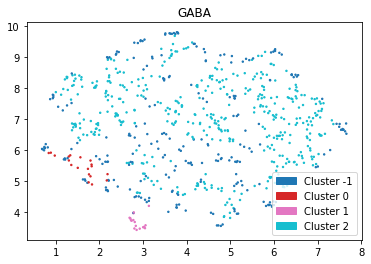

Cluster             -1    0    1      2
Country                                
American Samoa     5.0  NaN  NaN   11.0
Australia          1.0  NaN  NaN    NaN
Brazil             6.0  1.0  1.0    8.0
Burkina Faso      13.0  NaN  2.0   19.0
Costa Rica         NaN  NaN  NaN    1.0
French Polynesia   1.0  1.0  NaN    6.0
Gabon             20.0  2.0  NaN   34.0
Ghana             22.0  2.0  3.0   31.0
Kenya             42.0  3.0  5.0  108.0
LAB                2.0  NaN  NaN    4.0
Madagascar         NaN  1.0  1.0    2.0
Mauritius          NaN  NaN  NaN    3.0
Mexico             5.0  NaN  1.0    9.0
Nigeria            3.0  NaN  1.0   15.0
S. Africa          NaN  NaN  NaN    2.0
Senegal           34.0  3.0  1.0   72.0
Thailand          12.0  NaN  NaN   16.0
USA               68.0  6.0  4.0   83.0
Uganda            16.0  NaN  NaN   23.0


In [19]:
genes_to_plot={"XM_021852340.1":"VSSC", "XM_021851332.1":"ACE1","XM_021846286.1":"GSTE2", "XM_021840622.1":"GABA"}
for gene_id, gene_name in genes_to_plot.items():
    #add this to metadata to create table with coverage values and country values - this minimises redundancy of published tables.
    metadata[f'{gene_name}  median coverage']=np.median(coverageData.loc[ (coverageData["Gene"]==gene_id) & (coverageData["isCDS"]==True)][metadata.index],axis=0)

    data_to_embed=coverageData.loc[ (coverageData["Gene"]==gene_id) & (coverageData["isCDS"]==True)][numericColumns]
    embeddedVCF=umap.UMAP(n_neighbors=5, min_dist=0.01, unique=True, metric="euclidean", repulsion_strength=1, random_state=42).\
        fit_transform(np.transpose(data_to_embed))
    clusteringSNPs = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.5).fit(embeddedVCF).labels_    
    plt.scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=clusteringSNPs, cmap="tab10")
    plt.title(gene_name)
    print(Counter(clusteringSNPs))
    cluster_colour_dic={}
    legend_items=[]
    unique_clusters=list(set(clusteringSNPs))
    unique_clusters.sort()
    cluster_cmap=plt.cm.get_cmap('tab10', len(unique_clusters))
    for cluster in unique_clusters:
        cluster_colour_dic[cluster]=cluster_cmap( len(cluster_colour_dic) / len( unique_clusters ) )
        legend_items.append(mpatches.Patch(color=cluster_colour_dic[cluster], label="Cluster "+str(cluster)))
        #show the median coverage for each cluster
        print(f'{gene_name} cluster {cluster} median coverage: {np.median(data_to_embed[ [numericColumns[i] for i,f in enumerate(clusteringSNPs) if f==cluster   ]  ])}' )
    plt.legend( handles=legend_items )
    plt.show()    
    
    embedding_clusters=pd.DataFrame( data=clusteringSNPs, index= numericColumns )
    embedding_clusters=pd.DataFrame( data=clusteringSNPs, index= numericColumns, columns=["Cluster"] )
    embedding_clusters["Country"]=[metadata.at[f,"Country"] for f in numericColumns]
    embedding_clusters["values"]=range(0,len(embedding_clusters))
    print(pd.pivot_table(embedding_clusters, values="values",index=["Country"],columns=["Cluster"], aggfunc=np.count_nonzero))



Examine the coverage of excluded samples. The coverage is poor and uneven. Closer examination of covered regions reveals high coverage of repeat regions (expected), but low or no coverage of CDS regions

In [20]:
##parse MSA files with Ae. aegypti and reference proteins#
aAegyptiToReference={"ACE1":{},"VSSC":{},"GABA":{},"GSTE2":{}}
referenceDirs=f'{wd}/otherSpecies/'
alignmentFiles={"ACE1":"ACE_mafft.faa","GABA":"GABA_mafft.faa","VSSC":"VSSC_mafft.faa", "GSTE2":"GSTE2_mafft.faa"}
for gene in alignmentFiles:
    aedesSequence=""
    referenceSequence=""
    for record in SeqIO.parse(referenceDirs+alignmentFiles[gene],"fasta"):
        if aedesSequence=="":
            aedesSequence=str(record.seq)
        else:
            referenceSequence=str(record.seq)
    aedesPosition=0
    referencePosition=0
    for i in range(0,len(referenceSequence)):
        #only add positions if reference has non-blank there
        if referenceSequence[i]!="-":
            aAegyptiToReference[gene][aedesPosition]=referencePosition
        if aedesSequence[i]!="-":
            aedesPosition+=1
        if referenceSequence[i]!="-":
            referencePosition+=1


Compile the geography of SNPs. Change between sampleRegionsDic and sampleCountryDic to get country and region resolution

In [21]:
#rowsDic=sampleCountryDic
geography_level="SubRegion"
snpGeography=pd.DataFrame()
for region, count in  sorted(Counter( metadata["Region"] ).items(), key=lambda x: x[1], reverse=True):
    for geography in Counter(metadata[geography_level]):
        if metadata.loc[metadata[geography_level]==geography].iloc[0]["Region"]!=region:
            continue
        snpGeography.at[geography,"Total_Samples"]=len( [f for f in alleles_df.columns if f in metadata and metadata.at[f, geography_level]==geography] )
snpGeography.at["ReferenceOrgPosition","Total_Samples"]=""
snpGeography.loc["GenePosition"]=""
snpGeography.loc["Ref/Ref"]=0
snpGeography.loc["Ref/Alt"]=0
snpGeography.loc["Alt/Alt"]=0

geographyMasks={} #key=geography, value=list of sample columns
for index in snpGeography.index:
    geographyMasks[index] = [ x for x in alleles_df.columns if x not in nonNumericColumns and metadata.loc[x,geography_level]==index ]

def aedesPositionToReference(geneName, aaChange):
    #aaChange has format p.Ser61Leu
    aedesPosition=int(aaChange[5:-3])
    if aedesPosition in aAegyptiToReference[geneName]:
        return aaChange[0:5]+str(aAegyptiToReference[geneName][aedesPosition])+aaChange[-3:]
    else:
        return pd.NA

for gene in genesList.index[genesList["IsResistance"]]:
    mask=alleles_df.index[ (alleles_df["Gene"]==gene) & (alleles_df["SNPType"]!="REFERENCE") &
             ( get_mutations(alleles_df, "missense") | get_mutations(alleles_df, "high") ) & (alleles_df["isCDS"]==True) ]

    geneName=genesList.at[gene,"Name"]
    print( Counter(alleles_df.loc[mask]["SNPType"]) )

    for row in mask:
        
        if alleles_df.loc[row][numericColumns].sum()<1: #specify minimum allele frequency
            continue
        impact=alleles_df.at[row,"snpEffectImpact"]
        
        if impact=="MODERATE" and alleles_df.loc[row]["AAchange"]!="NA":
            columnID=geneName+"_"+alleles_df.loc[row]["AAchange"]   
        else:                              
            columnID=geneName+"_"+str(alleles_df.loc[row]["Pos"])+alleles_df.loc[row]["snpEffectOntology"]+alleles_df.loc[row]["AlleleSequence"]
        if impact in ["MODERATE","HIGH"] and geneName in aAegyptiToReference and alleles_df.loc[row]["AAchange"]!="NA":
            snpGeography.at["ReferenceOrgPosition" , columnID ] = aedesPositionToReference( geneName , alleles_df.loc[row]["AAchange"] )
        else:
            snpGeography.at["ReferenceOrgPosition" , columnID]=""

        for index in snpGeography.index:
            if index=="ReferenceOrgPosition":
                continue
            if impact=="MODERATE" and alleles_df.loc[row]["AAchange"]!="NA":
                snpGeography.at["GenePosition", columnID] = alleles_df.loc[row]["Gene"]+"_"+str(alleles_df.loc[row]["Pos"])
            snpGeography.at[index, columnID ]=np.sum(alleles_df.loc[row][geographyMasks[index]])
            ##there is a slight problem with how bcftools merges VCFs. In particular, it doesn't merge well different SNPs at the same positions
            ##as a result, the VCFs may end up with two line for same position which, when converted to matrix using current vcfTopandas.py
            ##gives two identical reference alleles. The .iloc[0] disregards the second reference allele.
            snpGeography.at["Ref/Ref",columnID]=( (alleles_df.loc[row][numericColumns]==0) & (alleles_df.loc[ (alleles_df["Pos"]==alleles_df.at[row,"Pos"]) &
                  (alleles_df["SNPType"]=="REFERENCE") ][numericColumns].iloc[0]==1) ).sum()
            snpGeography.at["Ref/Alt",columnID]=( (alleles_df.loc[row][numericColumns]==1) & (alleles_df.loc[ (alleles_df["Pos"]==alleles_df.at[row,"Pos"]) &
                  (alleles_df["SNPType"]=="REFERENCE") ][numericColumns].iloc[0]==1) ).sum()
            snpGeography.at["Alt/Alt",columnID]=( (alleles_df.loc[row][numericColumns]==1) & (alleles_df.loc[ (alleles_df["Pos"]==alleles_df.at[row,"Pos"]) &
                  (alleles_df["SNPType"]=="REFERENCE") ][numericColumns].iloc[0]==0) ).sum()

snpGeography=snpGeography[snpGeography.columns[np.where(np.sum(snpGeography.loc[set(metadata[geography_level])],axis=0)>0)[0]]] #unique mutaitons are hidden as there are likely noise
np.transpose(snpGeography).to_csv(outputData+"TableB.tsv", sep="\t")

Counter({'ALT': 67})
Counter({'ALT': 117})


/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Counter({'ALT': 107})
Counter({'ALT': 222})


In [22]:
Counter([metadata.loc[f,"SubRegion"] for f in numericColumns if metadata.loc[f,"SubRegion"]])
Counter([metadata.loc[f,"Country"] for f in numericColumns if metadata.loc[f,"SubRegion"]])

Counter({'French Polynesia': 9,
         'Thailand': 28,
         'Senegal': 110,
         'Kenya': 158,
         'Burkina Faso': 34,
         'Ghana': 58,
         'Nigeria': 19,
         'Madagascar': 4,
         'Gabon': 56,
         'Brazil': 16,
         'Uganda': 39,
         'USA': 161,
         'S. Africa': 2,
         'American Samoa': 16,
         'Mexico': 15,
         'LAB': 6,
         'Australia': 1,
         'Costa Rica': 1,
         'Mauritius': 3})

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  

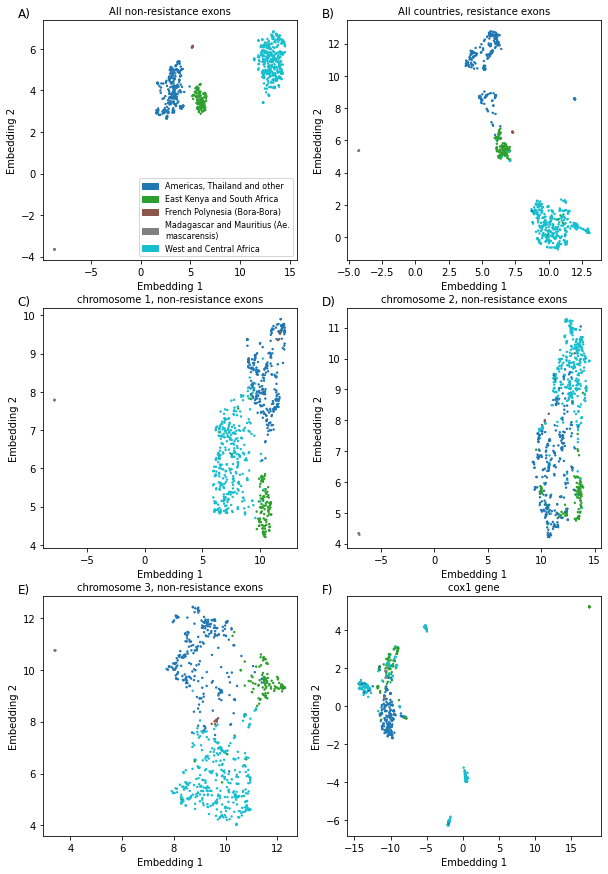

In [24]:
fig, axs = plt.subplot_mosaic( [ ["A)","B)"], ["C)", "D)"], ["E)","F)"] ])
fig.set_size_inches(10,15)
for label, ax in axs.items():
    ax.text(-0.1, 1.0, label, transform=ax.transAxes ,
            fontsize=12, va='bottom') 
method="umap"
snpThreshold=5

all_countries=[f for f in numericColumns if metadata.loc[f,"Country"]]
#all_countries_ex_mascarensis=[f for f in numericColumns if metadata.loc[f,"Country"] not in ["Mauritius", "Madagascar"]]
plot_data=[
    {"chr":"All", "is_resistance":[False], "countries":all_countries, "plot_pane":"A)", "title":"All non-resistance exons"},
    {"chr":"All", "is_resistance":[True], "countries":all_countries, "plot_pane":"B)", "title":"All countries, resistance exons"},    
    {"chr":'NC_035107.1', "is_resistance":[False], "countries":all_countries, "plot_pane":"C)", "title":"chromosome 1, non-resistance exons"},
    {"chr":'NC_035108.1', "is_resistance":[False], "countries":all_countries, "plot_pane":"D)", "title":"chromosome 2, non-resistance exons"},    
    {"chr":'NC_035109.1', "is_resistance":[False], "countries":all_countries, "plot_pane":"E)", "title":"chromosome 3, non-resistance exons"},    
    {"chr":'NC_035159.1', "is_resistance":[False], "countries":all_countries, "plot_pane":"F)", "title":"cox1 gene"},    
]
plot_coordinates_df=pd.DataFrame(index=all_countries, dtype=float)

for item in plot_data:
    snpFrequency=np.asarray(np.sum(alleles_df[item["countries"]],axis=1))
    if item["chr"]=="All":
        subset=alleles_df.index[ (snpFrequency>=snpThreshold) & ( get_mutations(alleles_df,"synonymous") | 
                                                                  get_mutations(alleles_df,"missense") | 
                                                                  get_mutations(alleles_df,"modifier") ) & 
                                    ( snpFrequency<=( len(item["countries"])-snpThreshold) )   &
                                    ( alleles_df["Gene"].isin(  genesList.index[ (   genesList["IsResistance"].isin(item["is_resistance"])    )  ] )) ]     
    else:
        subset=alleles_df.index[np.where(  alleles_df["Gene"].isin(  genesList.index[ ( genesList["IsResistance"].isin(item["is_resistance"]) )   & (genesList["Chr"]==item["chr"])]  ) &
                                    (snpFrequency>=snpThreshold) & ( get_mutations(alleles_df,"synonymous") | 
                                                        get_mutations(alleles_df,"missense") | 
                                                        get_mutations(alleles_df,"modifier") ) & 
                                    ( snpFrequency<=( len(item["countries"])-snpThreshold) ) )[0]]        
            

    embeddingData=np.transpose(alleles_df.loc[subset, item["countries"]])
    embeddedVCF=umap.UMAP(n_neighbors=10, min_dist=0.01, unique=True, metric="russellrao",  random_state=40).fit_transform(embeddingData)

    axs[item["plot_pane"]].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=2, c=[   regionColoursDic[metadata.at[f,"Region"]] for f in item["countries"]])    
    axs[item["plot_pane"]].set_ylabel("Embedding 2")
    axs[item["plot_pane"]].set_xlabel("Embedding 1")  
    plot_coordinates_df.loc[  item["countries"],  f'{item["title"]}_X' ] = embeddedVCF[:,0]
    plot_coordinates_df.loc[  item["countries"],  f'{item["title"]}_Y' ] = embeddedVCF[:,1]
    
    axs[item["plot_pane"]].set_title(item["title"], fontdict={'fontsize': 10, 'fontweight': 'medium'})


#legend needs to be set manually and only for one subplot to avoid mess
legendElements=[]
for key in regionColoursDic:
    if key in Counter(metadata.loc[plot_data[0]["countries"]]["Region"]):
        if len(legendElements)<9:
            legendElements.append(mpatches.Patch(color=regionColoursDic[key], label= '\n'.join(wrap(key, 30))   ))
        else:
            legendElements.append(mpatches.Patch(color=regionColoursDic[key], label="Other"))
            break

axs["A)"].legend(handles=legendElements,prop={'size': 8}, loc="lower right")
plt.show()

plot_coordinates_df.to_csv(f'{outputData}/FigA_coordinates.tsv', sep="\t")

/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/mnt/storage5/anton/miniconda3/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  

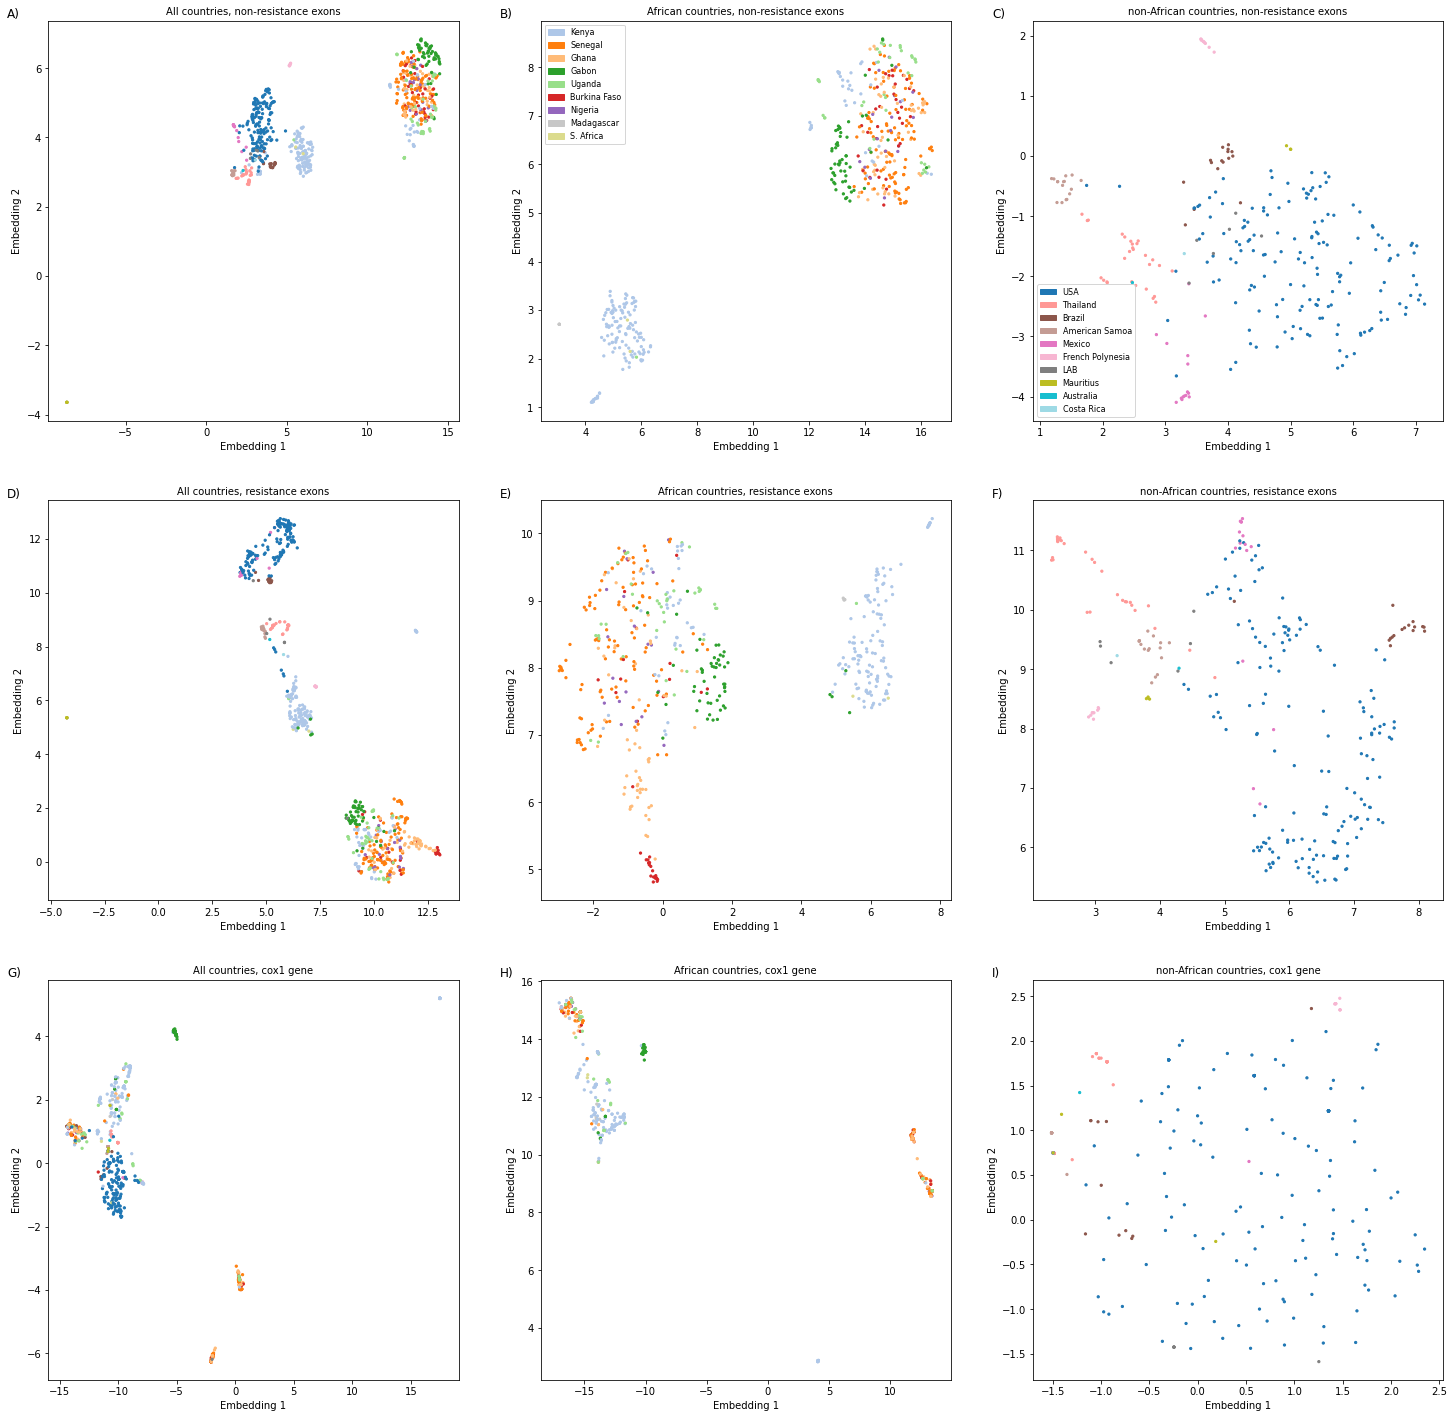

In [41]:
fig, axs = plt.subplot_mosaic( [ ["A)","B)", "C)"],["D)","E)", "F)"],["G)","H)", "I)"] ])
fig.set_size_inches(25,25)
for label, ax in axs.items():
    ax.text(-0.1, 1.0, label, transform=ax.transAxes ,
            fontsize=12, va='bottom') 

non_africa=[f for f in numericColumns if metadata.loc[f,"Country"] in ["Australia", "American Samoa","Brazil", "Mexico","Thailand","Mauritius","Costa Rica", "USA", "French Polynesia", "LAB"]]
only_africa=[f for f in numericColumns if f not in non_africa]
all_countries=[f for f in numericColumns if metadata.loc[f,"Country"]]

countryColoursDic={}
country_legend_elements=[]
countriesPresent=sorted(Counter([ metadata.at[f,"Country"] for f in all_countries]).items(), key=lambda x: x[1], reverse=True)
regionsCmap=plt.cm.get_cmap('tab20', min(len(countriesPresent),20))
for country, count in countriesPresent:
    countryColoursDic[country]=regionsCmap( len(countryColoursDic)  )
    country_legend_elements.append(mpatches.Patch(color=countryColoursDic[country], label=country))

method="umap"
snpThreshold=5

plot_data=[
    {"chr":"All", "is_resistance":[False], "countries":all_countries, "plot_pane":"A)", "title":"All countries, non-resistance exons"},
    {"chr":"All", "is_resistance":[False], "countries":only_africa, "plot_pane":"B)", "title":"African countries, non-resistance exons"},
    {"chr":"All", "is_resistance":[False], "countries":non_africa, "plot_pane":"C)", "title":"non-African countries, non-resistance exons"},    

    {"chr":"All", "is_resistance":[True], "countries":all_countries, "plot_pane":"D)", "title":"All countries, resistance exons"},
    {"chr":"All", "is_resistance":[True], "countries":only_africa, "plot_pane":"E)", "title":"African countries, resistance exons"},
    {"chr":"All", "is_resistance":[True], "countries":non_africa, "plot_pane":"F)", "title":"non-African countries, resistance exons"},

    {"chr":"NC_035159.1", "is_resistance":[False], "countries":all_countries, "plot_pane":"G)", "title":"All countries, cox1 gene"},
    {"chr":"NC_035159.1", "is_resistance":[False], "countries":only_africa, "plot_pane":"H)", "title":"African countries, cox1 gene"},
    {"chr":"NC_035159.1", "is_resistance":[False], "countries":non_africa, "plot_pane":"I)", "title":"non-African countries, cox1 gene"}
]


# for chr, is_resistance, columns_to_use, chart_pane in zip(["All", "resistance", "resistance", "NC_035159.1"],
#                                            [False, True, True, True, False],
#                                            [all_countries, all_countries,only_africa, non_africa,all_countries],
#                                            ["A)","B)","C)","D)"],
#                                            ["All countries, non-resistance exons"]):#, "resistance"]+list(Counter(genesList["Chr"]).keys()):
for item in plot_data:
    snpFrequency=np.asarray(np.sum(alleles_df[item["countries"]],axis=1))
    if item["chr"]=="All":
        subset=alleles_df.index[ (snpFrequency>=snpThreshold) & ( get_mutations(alleles_df,"synonymous") | 
                                                                  get_mutations(alleles_df,"missense") | 
                                                                  get_mutations(alleles_df,"modifier") ) & 
                                    ( snpFrequency<=( len(item["countries"])-snpThreshold) )   &
                                    ( alleles_df["Gene"].isin(  genesList.index[ (   genesList["IsResistance"].isin(item["is_resistance"])    )  ] )) ]     
    else:
        subset=alleles_df.index[np.where(  alleles_df["Gene"].isin(  genesList.index[ ( genesList["IsResistance"].isin(item["is_resistance"]) )   & (genesList["Chr"]==item["chr"])]  ) &
                                    (snpFrequency>=snpThreshold) & ( get_mutations(alleles_df,"synonymous") | 
                                                        get_mutations(alleles_df,"missense") | 
                                                        get_mutations(alleles_df,"modifier") ) & 
                                    ( snpFrequency<=( len(item["countries"])-snpThreshold) ) )[0]]   
  
    if len(subset)==0:
        continue
    
    embeddingData=np.transpose(alleles_df.loc[subset][item["countries"]])
    embeddedVCF=umap.UMAP(n_neighbors=10, min_dist=0.01, unique=True, metric="russellrao",  random_state=40).fit_transform(embeddingData)
    
    axs[item["plot_pane"]].scatter(embeddedVCF[:,0],embeddedVCF[:,1], s=5, c=[   countryColoursDic[metadata.at[f,"Country"]] for f in item["countries"]])    
    axs[item["plot_pane"]].set_ylabel("Embedding 2")
    axs[item["plot_pane"]].set_xlabel("Embedding 1")  
    
    axs[item["plot_pane"]].set_title(item["title"], fontdict={'fontsize': 10, 'fontweight': 'medium'})

#legend needs to be set manually and only for one subplot to avoid mess
africa_legend=[]
non_africa_legend=[]
for key in sorted(Counter([ metadata.at[f,"Country"] for f in only_africa ]).items(), key=lambda x: x[1], reverse=True):
    if len(africa_legend)<20:
        africa_legend.append(mpatches.Patch(color=countryColoursDic[key[0]], label=key[0]))
    else:
        africa_legend.append(mpatches.Patch(color=countryColoursDic[key[0]], label="Other"))
        break
for key in sorted(Counter([ metadata.at[f,"Country"] for f in non_africa ]).items(), key=lambda x: x[1], reverse=True):
    if len(non_africa_legend)<20:
        non_africa_legend.append(mpatches.Patch(color=countryColoursDic[key[0]], label=key[0]))
    else:
        non_africa_legend.append(mpatches.Patch(color=countryColoursDic[key[0]], label="Other"))
        break

axs["B)"].legend(handles=africa_legend,prop={'size': 8}, loc="upper left")

axs["C)"].legend(handles=non_africa_legend,prop={'size': 8}, loc="lower left")

plt.show()

